In [2]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
MAX_TOWERS = 6
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
np.random.seed(17)
import random
random.seed(17)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def get_train():
    train_main = pd.read_csv("../data/task1/train_1.7.csv", encoding="cp1251")
    train_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    train_aux_frac = pd.read_csv("../data/task1_additional/frac_train_1.csv", encoding="cp1251")
    train_aux_gdis = pd.read_csv("../data/task1_additional/gdis_train1.2.csv", encoding="cp1251")
    
    
    train_frac_main = pd.merge(train_main, train_aux_frac,how="left", left_on="Скважина", right_on="Скважина")
    all_recs = pd.merge(train_frac_main, train_aux_gdis,how="left", left_on="Скважина", right_on="Скважина")
    print(all_recs.shape)
    return all_recs

def get_test():
    test_main = pd.read_csv("../data/task1/test_1.9.csv", encoding="cp1251")
    test_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    test_aux_frac = pd.read_csv("../data/task1_additional/frac_test_1.csv", encoding="cp1251")
    test_aux_gdis = pd.read_csv("../data/task1_additional/gdis_test1.2.csv", encoding="cp1251")
    
    
    test_frac_main = pd.merge(test_main, test_aux_frac,how="left", left_on="Скважина", right_on="Скважина")
    all_recs = pd.merge(test_frac_main, test_aux_gdis,how="left", left_on="Скважина", right_on="Скважина")
    print(all_recs.shape)
    return all_recs

In [4]:
#sort by converted date and group
def convert_and_sort(df):
    df["Дата"] =  df["Дата"].apply(pd.to_datetime)
    return df.sort_values(by=["Скважина", "Дата"])

def get_non_useful(df):
    non_useful_columns = []
    for c in df.columns:
        null_columns = df[df[c].isnull()]
        if len(null_columns)== len(df):
            non_useful_columns.append(c)
    return non_useful_columns

def drop_non_useful(train, test):
    non_useful = set(get_non_useful(train)) |set(get_non_useful(test))
    print("%s dropped"% non_useful)
    return train.drop(list(non_useful), axis=1), test.drop(list(non_useful), axis=1)

def get_float(v):
    v = str(v)
    if v != "NaN":
        new = v.replace(",",".")
        return float(new)
    return v

def get_target(df, column="Нефть, т"):
    target = df[column]
    print("%s dropped"% column)
    return df.drop([column], axis=1), target.apply(get_float)

#drop non present columns in test
def drop_not_present(train, test):
    absent_columns = list(set(train.columns) - set(test.columns))
    print("%s dropped"% absent_columns)
    return train.drop(absent_columns, axis=1), test
    
def show_uniq_test_train(train, test):
    #check all values that have zero ans nan only
    for c in sorted(train.columns):
        un = train[c].unique()
        if len(un)<100:
            tun = test[c].unique()
            print("%s ;train: %s; test:%s"%(c, un, tun))

In [5]:
def common_data_pipeline(train, test):
    print(train.shape)
    print(test.shape)
    
    y = None
    train=convert_and_sort(train)
    train, test = drop_non_useful(train, test)
    #remove target from train
    train, y = get_target(train)
    train, test = drop_not_present(train, test)
    print(train.shape)
    print(test.shape)
    
    return train, test, y

In [6]:
def get_existed(columns, df):
    return list(set(columns)&set(df.columns))

def split_continious_date_categorical_text(df):
    group_id = ["Скважина"]
    text = ["Причина простоя"]
    categorical = ["Тип испытания",
                   "Тип скважины",
                   "Неустановившийся режим",
                   "ГТМ",
                   "Метод",
                   "Характер работы",
                   "Состояние",
                   "Пласт МЭР", 
                   "Способ эксплуатации", 
                   "Тип насоса", 
                   "Состояние на конец месяца", 
                   "Номер бригады", 
                   "Фонтан через насос", 
                   "Нерентабельная",
                   "Назначение по проекту",
                   "Группа фонда",
                   "Тип дополнительного оборудования",
                   "Марка ПЭД",
                   "Тип ГЗУ",
                   "ДНС",
                   "КНС",
                   #useless potentially
                   "Диаметр плунжера",
                   "Природный газ, м3",
                   "Конденсат, т",
                   "Длина хода плунжера ШГН",
                   "Коэффициент подачи насоса",
                   "Дебит конденсата",
                   "Вязкость воды в пластовых условиях",
                   "Газ из газовой шапки, м3",
                   "Число качаний ШГН",
                   "Коэффициент сепарации",
                   "SKIN",
                   "КН закрепленный",
                   # radically different
                   "Время в работе",
                   "Радиус контура питания",
                   "Время в накоплении",
                   "Время накопления",
                   "Агент закачки",
                   # text converted
                   "Мероприятия",
                   "Проппант",
                   "Куст",
                   "Состояние на конец месяца",
                   "Причина простоя.1",
                   ]
    dates = ["Дата", 
             "Дата ГРП",
             "Время до псевдоуст-ся режима", 
             "Дата запуска после КРС", 
             "Дата пуска", 
             "Дата останова",
             "Дата ввода в эксплуатацию"]
    exclude = ["Дата ГРП",
               "Время до псевдоуст-ся режима", 
               "Дата запуска после КРС", 
               "Дата пуска", 
               "Дата останова",
               "Дата ввода в эксплуатацию"]
    cont_list = [['ТП - JD опт.', 
                  'М пр', 
                  'Характеристический дебит жидкости', 
                  'М бр', 
                  'Наклон', 
                  'Добыча растворенного газа, м3', 
                  'Приемистость, м3/сут', 
                  'Давление в линии', 
                  'Частота', 
                  'JD факт', 
                  'Напор', 
                  'Давление пластовое', 
                  'Пластовое давление начальное', 
                  'Обводненность', 
                  'Вязкость жидкости в пласт. условиях', 
                  'Удлинение', 
                  'Коэффициент продуктивности', 
                  'объемный коэффициент', 
                  'JD', 
                  'Низ', 
                  'Динамическая высота', 
                  'Температура пласта', 
                  'Затрубное давление', 
                  'Попутный газ, м3', 
                  'ТП - Забойное давление', 
                  'Замерное забойное давление', 
                  'ГП - Забойное давление', 
                  'Верх', 
                  'Забойное давление', 
                  'Пластовое давление', 
                  'Hf', 
                  'Диаметр штуцера', 
                  'ГП(ГРП) Дебит жидкости', 
                  'Газовый фактор', 
                  'Глубина спуска доп. оборудования', 
                  'V гель', 
                  'Эфф', 
                  'Диаметр НКТ', 
                  'Обводненность (вес), %', 
                  'Рпл Хорнер', 
                  'k', 
                  'К пр от стимуляции', 
                  'Закачка, м3', 
                  'ТП - SKIN', 
                  'ГП(ИДН) Дебит жидкости', 
                  'Гель', 
                  'Плотность раствора глушения', 
                  'Конц', 
                  'КВЧ', 
                  'Вязкость нефти в пластовых условиях', 
                  'Буферное давление', 
                  'FCD', 
                  'Удельный коэффициент', 
                  'Pпл', 
                  'Ток рабочий', 
                  'Глубина текущего забоя', 
                  'Дебит попутного газа, м3/сут', 
                  'Простой, ч', 
                  'Глубина спуска', 
                  'Диаметр экспл.колонны', 
                  'Wf', 
                  'Диаметр дополнительного оборудования', 
                  'Глубина спуска.1', 
                  'Азимут', 
                  'Производительность ЭЦН', 
                  'Давление наcыщения', 
                  'Нефтенасыщенная толщина', 
                  'ГП(ГРП) Дебит жидкости скорр-ый', 
                  'Время работы, ч', 
                  'Плотность нефти', 
                  'I X/X', 
                  'ГП(ИДН) Дебит жидкости скорр-ый', 
                  'Ток номинальный', 
                  'Ноб', 
                  'V под', 
                  'Давление на приеме', 
                  'Xf',
                  'Плотность воды', 
                  'Высота перфорации', 
                  'Глубина верхних дыр перфорации', 
                  'Мощность ПЭД', 
                  'Нэф', 
                  'ГП(ИДН) Прирост дефита нефти']]
    continious = list(set(df.columns) - set(dates) - set(categorical) - set(text) - set(group_id))
    return (df[group_id],df[continious], df[get_existed(dates,df)], df[get_existed(categorical, df)],
            df[get_existed(text, df)])

In [7]:
def get_object_columns(df):
    objects = []
    for c in df.columns:
        if df[c].dtype != pd.np.float:
            objects.append(c)
    return objects

def convert_locale_to_float(df):
    loc_float = get_object_columns(df)
    converted = df.copy()
    for c in loc_float:
        converted.loc[:,c] = df[c].apply(get_float)
    return converted
        
def fill_with_mean(train, test):
    means=train.mean()
    norm_train = train.fillna(means)
    norm_test = test.fillna(means)
    return norm_train, norm_test

# now we have clear non-normalized data, let's normalize first
def normalize(train, test):
    scaler = StandardScaler()
    norm_train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
    norm_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index = test.index)
    return norm_train, norm_test

In [8]:
def cont_transform_pipeline(train, test):
    train_f = convert_locale_to_float(train)
    test_f = convert_locale_to_float(test)
    train_cont, test_cont = fill_with_mean(train_f, test_f)
    train_cont, test_cont = normalize(train_cont, test_cont)
    print(train_cont.isnull().values.any() or test_cont.isnull().values.any())
    
    print(train_cont.shape)
    print(test_cont.shape)
    return train_cont, test_cont

In [9]:
def transform_cats_to_labels(train_cat, test_cat):
    transformed_df = train_cat.copy()
    trans_test = test_cat.copy()
    for c in train_cat.columns:
        encoder = LabelEncoder()
        column_train = train_cat[c].astype(str)
        column_test = test_cat[c].astype(str)
        combined = pd.concat([column_train, column_test])
        encoder.fit(combined)
        transformed_df[c] = encoder.transform(column_train).reshape(-1,1)
        trans_test[c] = encoder.transform(column_test).reshape(-1,1)
    return transformed_df, trans_test

In [10]:
def cat_transform_pipeline(train, test):
    train_cat, test_cat = transform_cats_to_labels(train, test)
    print(train_cat.shape)
    print(test_cat.shape)
    return train_cat, test_cat

In [11]:
def text_trasnsform_pipeline(train, test):
    if "Причина простоя" in train.columns:
        train_txt = train["Причина простоя"].str.lower()
        test_txt = test["Причина простоя"].str.lower()
        return train_txt, test_txt
    return train, test

In [12]:
def transform_dates_into_order(dates, group):
    grouped = pd.concat([dates, group], axis=1)
    idx = []
    orders = []
    for name,group in grouped.groupby(["Скважина"]):
        index = group.index
        for i in range(len(index)):
            idx.append(index[i])
            orders.append(i)
    ord_index = pd.Index(idx)
    ordered_fr = pd.Series(orders, index=ord_index, dtype="int32",name="order")
    return ordered_fr

def dates_transform_pipeline(train, test, train_group):
    train_cont = train.drop(["Дата"], axis =1)
    train_cat = train["Дата"].apply(pd.to_datetime)
    train_cat = transform_dates_into_order(train_cat, train_group)
    test_cont = test.drop(["Дата"], axis =1)
    test_cat = test["Дата"].apply(pd.to_datetime)
    test_cat = pd.Series(0, index=test_cat.index, dtype="int32", name="order")
    return train_cont, test_cont, train_cat, test_cat

In [24]:
def clean_non_targeted(train_array, y_train):
    clean_array = []
    train_array.append(y_train)
    #clear nans in target
    indexes_to_delete = y_train[(y_train.isnull())|(y_train==0)].index
    for df in train_array:
        item = df.drop(index=indexes_to_delete)
        clean_array.append(item)
        print(item.shape)
    return clean_array

In [14]:
def get_preds_for_cats(train, test, y):
    cb_regressor = CatBoostRegressor(logging_level="Silent")
    train_catboost_preds = cross_val_predict(cb_regressor, train, y)
    cb_regressor.fit(train,y=y)
    test_catboost_preds = pd.Series(cb_regressor.predict(test), index=test.index)
    return train_catboost_preds, test_catboost_preds

In [15]:
def get_cont_ensemble():
    ridge = Ridge()
    rtree = RandomForestRegressor(n_jobs=-1, n_estimators=50)
    svr = LinearSVR()
    return [ridge, rtree, svr]

def get_cont_ensemble_names():
    return ["ridge", "rtree", "svr"]

In [16]:
def get_meta_train_preds(X, y, train_mixture, mix_cols):
    predicts = []
    for cl in get_cont_ensemble():
        predicts.append(cross_val_predict(cl, X,y, n_jobs=-1))
    predicts.append(train_mixture)
    return pd.DataFrame(np.vstack(predicts).transpose(), index=y.index, columns=get_cont_ensemble_names()+mix_cols)

def get_meta_test_predict(X_train, y_train, X_test, test_mixture, mix_cols):
    test_predicts = []
    for cl in get_cont_ensemble():
        print(cross_val_score(cl, X_train, y_train, n_jobs=-1, scoring="neg_mean_absolute_error"))
        cl.fit(X_train, y_train)
        pr = cl.predict(X_test)
        test_predicts.append(pr)
    test_predicts.append(test_mixture)
    return  pd.DataFrame(np.vstack(test_predicts).transpose(), index=X_test.index, columns=get_cont_ensemble_names()+mix_cols)

def get_stacked_ensemble_predict(X_meta, y, X_test):
    regressor = xgb.XGBRegressor()
    regressor.fit(X_meta, y)
    return pd.DataFrame(regressor.predict(X_test), index=X_test.index)

In [17]:
def get_n_item_index(group_size, df, group):
    new_df = pd.concat([df, group], axis = 1)
    index = []
    group = new_df.groupby(["Скважина"])
    for name, group in group:
        if len(group)<group_size:
            continue
        for start in range(len(group.index) - group_size):
            gr =group.index[start:start+group_size]
            index.append(gr)
    return index

def get_timed_ds(meta_size, df, group, y):
    if meta_size >= 1:
        meta_indexes = get_n_item_index(meta_size, df, group)
        first_value_idx = []
        timed_ds = df.copy()
        metas = []
        columns = []
        for i in range(meta_size):
            columns.append("meta%s"%str(i))
        for a in meta_indexes:
            first_value_idx.append(a[0])
            metas.append(list(y.loc[a]))
        metas_df = pd.DataFrame.from_records(metas, index=first_value_idx, columns=columns)
        return pd.concat([timed_ds.loc[first_value_idx], metas_df], axis=1)
    elif meta_size == 0:
        return df
    
def get_n_tower_predictions(n, train, y, test, train_group, train_mix, test_mix, mix_col,):
    X_meta_train = get_meta_train_preds(train, y, train_mixture=train_mix, mix_cols=mix_col)
    X_meta_test = get_meta_test_predict(train, y, test, test_mixture=test_mix, mix_cols=mix_col)
    test_predictions= []
    for i in range(0,n):
        train_timed_ds = get_timed_ds(i,X_meta_train, train_group, y)
        y_timed = y.loc[train_timed_ds.index]
        test_predict = get_stacked_ensemble_predict(train_timed_ds, y_timed,X_meta_test)
        test_predictions.append(test_predict)
        X_meta_test["meta%s"%i]=test_predict
    return pd.concat(test_predictions,axis=1)

In [18]:
def create_submission(fname, df):
    final_pred = pd.Series(df)
    final_pred.to_csv(fname,header=["_VAL_"],index_label=["_ID_"])

In [19]:
def get_clean_data(train, test):
    train, test, y_train  = common_data_pipeline(train, test)
    train_group, train_cont, train_dat, train_cat, train_text = split_continious_date_categorical_text(train)
    test_group, test_cont, test_dat, test_cat, test_text = split_continious_date_categorical_text(test)
    train_dat_cont, test_dat_cont, train_dat_cat, test_dat_cat = dates_transform_pipeline(
        train_dat, test_dat, train_group)
    train_text, test_text = text_trasnsform_pipeline(train_text, test_text)
    train_cont = pd.concat([train_cont, train_dat_cont], axis = 1)
    train_cat = pd.concat([train_cat, train_dat_cat, train_text], axis = 1)
    test_cont = pd.concat([test_cont, test_dat_cont], axis = 1)
    test_cat = pd.concat([test_cat, test_dat_cat, test_text], axis = 1)
    train_cont, test_cont = cont_transform_pipeline(train_cont, test_cont)
    train_cat, test_cat = cat_transform_pipeline(train_cat, test_cat)
    train_cont, train_group, train_cat, y_train = clean_non_targeted([train_cont, train_group, train_cat], y_train)
    train_cat_preds, test_cat_preds = get_preds_for_cats(train_cat, test_cat, y_train)
    return train_cont, y_train, test_cont, train_group, train_cat_preds, test_cat_preds

In [20]:
def get_prediction(train, test, constant = 701.4750):
    train_cont, y_train, test_cont, train_group, train_cat_preds, test_cat_preds = get_clean_data(train,test)
    time_serie_pred = get_n_tower_predictions(
        6, train_cont, y_train,test_cont, train_group, train_cat_preds, test_cat_preds, ["catboost"]
    ).values.reshape(-1,1)
    time_serie_pred = np.squeeze(time_serie_pred)
    print(constant - np.mean(time_serie_pred))
    final_pred = time_serie_pred + (constant - np.mean(time_serie_pred))
    return final_pred

In [32]:
preds = get_prediction(get_train(), get_test())

(5735, 147)
(319, 138)
(5735, 147)
(319, 138)
{'Станок-качалка', 'Фирма ГРП', 'Тип газосепаратора', 'Агент закачки', 'Примечание'} dropped
Нефть, т dropped
['Нефть, м3', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости', 'Дебит жидкости', 'ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Жидкость, м3'] dropped
(5735, 133)
(319, 133)
False
(5735, 89)
(319, 89)
(5735, 43)
(319, 43)
(3720, 89)
(3720, 1)
(3720, 43)
(3720,)
[-141.73745211 -154.5051776  -151.9946621 ]
[-61.96887645 -69.42671306 -75.13937355]
[-111.52985923 -147.44449235 -130.47615103]
450.56617126464846


In [33]:
create_submission("all_data_submit_non_zeros.csv", preds)

In [28]:
def get_cleaned_test(test, size=6):
    test, y_test = get_target(test)
    test, y_test = clean_non_targeted([test], y_test)
    X_idx = []
    y_idx = []
    group = test.groupby(["Скважина"])
    for name, group in group:
        if len(group)!= size:
            continue
        X_idx.append(group.index[0])
        y_idx.extend(group.index)
    if X_idx and y_idx:
        test = test.loc[X_idx]
        y_test = y_test[y_idx]
        constant = np.mean(y_test.values)
        return test, y_test, constant
    else:
        return None, None, None

In [29]:
def cross_validate(train, n_folds = 4):
    errors = []
    k_fold = KFold(n_splits=n_folds)
    for tr_ix, test_ix in k_fold.split(train):
        print("new fold started")
        train_cv = train.iloc[tr_ix]
        test_cv = train.iloc[test_ix]
        test_cv, y_test, constant = get_cleaned_test(test_cv)
        test_preds = get_prediction(train_cv, test_cv, constant=constant)
        error=mean_absolute_error(y_true=y_test, y_pred=test_preds)
        print("fold error:%s" % error)
        errors.append(error)
    print("overall error: %s" % np.mean(errors))
    print(errors)

In [30]:
%%time
cross_validate(get_train())

(5735, 147)
new fold started
Нефть, т dropped
(1095, 146)
(1095,)
(4301, 147)
(27, 146)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Станок-качалка', 'Тип газосепаратора', 'Причина простоя.1', 'Марка ПЭД', 'Примечание', 'Фирма ГРП', 'Агент закачки', 'Тип дополнительного оборудования', 'Мероприятия', 'JD', 'КНС'} dropped
Нефть, т dropped
[] dropped
(4301, 135)
(27, 135)
False
(4301, 96)
(27, 96)
(4301, 38)
(27, 38)
(2625, 96)
(2625, 1)
(2625, 38)
(2625,)
[-4.8434497  -5.58794518 -5.42702298]
[ -9.21875109  -9.04118377 -10.75824411]
[-24.83186522 -28.98402947 -32.24552667]
-203.11526665581596
fold error:267.45969725620597
new fold started
Нефть, т dropped
(792, 146)
(792,)
(4301, 147)
(20, 146)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Высота перфорации', 'Тип газосепаратора', 'Забойное давление', 'Глубина спуска.1', 'К пр от стимуляции', 'ТП(ИДН) Дебит жидкости скорр-ый', 'Нефтенасыщенная толщина', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Производительность ЭЦН', 'Дата ГРП', 'КНС', 'ГП(ИДН) Дебит жидкости', 'Состояние на конец месяца', 'ТП - JD опт.', 'Тип ГЗУ', 'ГП(ГРП) Дебит жидкости скорр-ый', 'Марка ПЭД', 'объемный коэффициент', 'ТП(ИДН) Дебит жидкости', 'Плотность воды', 'Замерное забойное давление', 'Характеристический дебит жидкости', 'Пластовое давление начальное', 'Мероприятия', 'КВЧ', 'Время до псевдоуст-ся режима', 'Тип насоса', 'Давление наcыщения', 'Неустановившийся режим', 'Дата ввода в эксплуатацию', 'Мощность ПЭД', 'Удлинение', 'Глубина текущего забоя', 'Динамическая высота', 'Обводненность', 'Примечание', 'Удельный коэффициент', 'Станок-качалка', 'Давление в линии', 'Диаметр плунжера', 'КН закрепленный', 'Затрубное давление', 'ТП - Забойное давление', 'Коэффициент продуктивности', 'JD факт', 'Температу

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Станок-качалка', 'Тип газосепаратора', 'Причина простоя.1', 'Фирма ГРП', 'Агент закачки', 'Мероприятия', 'Примечание'} dropped
Нефть, т dropped
[] dropped
(4301, 139)
(20, 139)
False
(4301, 97)
(20, 97)
(4301, 41)
(20, 41)
(2731, 97)
(2731, 1)
(2731, 41)
(2731,)
[-4.77085653 -5.74640564 -6.6632141 ]
[-10.4833809  -10.12998242 -11.70863473]
[-19.66517606 -27.24812513 -25.09852665]
-26.624308349609407
fold error:81.43385848363239
new fold started
Нефть, т dropped
(844, 146)
(844,)
(4302, 147)
(9, 146)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Станок-качалка', 'Тип газосепаратора', 'Причина простоя.1', 'Причина простоя', 'Фирма ГРП', 'Агент закачки', 'Мероприятия', 'Примечание'} dropped
Нефть, т dropped
[] dropped
(4302, 138)
(9, 138)
False
(4302, 97)
(9, 97)
(4302, 40)
(9, 40)
(2876, 97)
(2876, 1)
(2876, 40)
(2876,)
[-3.1215149  -3.37573433 -3.78759195]
[-3.50468259 -7.73172117 -6.36077474]
[-15.18471142 -18.10664997 -16.38720743]
-553.4884221281828
fold error:513.5876102701824
overall error: 285.9852514405545
[267.45969725620597, 281.4598397521973, 81.43385848363239, 513.5876102701824]
CPU times: user 3min 39s, sys: 31.9 s, total: 4min 11s
Wall time: 1min 53s


In [27]:
299.720573012412
[289.9811313784219, 335.9357574203388, 126.81710257918746, 446.1483006716997]
300.25068988386926
[290.65788832253554, 336.1340891623984, 127.1327437987151, 447.07803825182793]
300.18614828409784
[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]
285.9852514405545
[267.45969725620597, 281.4598397521973, 81.43385848363239, 513.5876102701824]

[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]

# eda part

In [21]:
train = get_train()
test = get_test()
train_group = train["Скважина"]
y_train = train["Нефть, т"]

(5735, 147)
(319, 138)


In [23]:
y_train[]

2       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
21      NaN
40      NaN
45      NaN
64      NaN
75      NaN
92      NaN
93      NaN
127     NaN
128     NaN
129     NaN
130     NaN
131     NaN
146     NaN
147     NaN
150     NaN
151     NaN
152     NaN
153     NaN
154     NaN
155     NaN
161     NaN
183     NaN
184     NaN
185     NaN
224     NaN
225     NaN
226     NaN
227     NaN
243     NaN
244     NaN
245     NaN
270     NaN
271     NaN
272     NaN
273     NaN
274     NaN
275     NaN
276     NaN
277     NaN
278     NaN
279     NaN
280     NaN
281     NaN
480     NaN
481     NaN
482     NaN
483     NaN
484     NaN
485     NaN
486     NaN
487     NaN
488     NaN
489     NaN
490     NaN
491     NaN
728     NaN
729     NaN
762     NaN
763     NaN
764     NaN
765     NaN
766     NaN
767     NaN
768     NaN
769     NaN
770     NaN
771     NaN
772     NaN
773     NaN
774     NaN
775     NaN
776 

In [47]:
train_cont, y_train_clean, test_cont, train_group, train_cat_preds, test_cat_preds = get_clean_data(train, test)

(5735, 147)
(319, 138)
{'Примечание', 'Станок-качалка', 'Тип газосепаратора', 'Агент закачки', 'Фирма ГРП'} dropped
Нефть, т dropped
['Нефть, м3', 'ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Дебит жидкости', 'Жидкость, м3', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости'] dropped
(5735, 133)
(319, 133)
False
(5735, 89)
(319, 89)
(5735, 43)
(319, 43)
(4764, 89)
(4764, 1)
(4764, 43)
(4764,)


In [31]:
y_train.shape

(4764,)

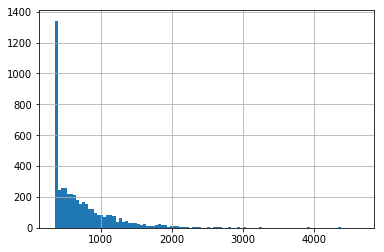

In [39]:
(y_train+350).hist(bins =100)

In [37]:
2*y_train.mean()

728.5548992443325

In [59]:
dates_cont, dates_cont, dates_cat, _ = dates_transform_pipeline(train, test, train_group)

In [60]:
dates_cat.shape

(5735,)

In [89]:
y_train = y_train.fillna(0).apply(get_float)
y_train = y_train[y_train!=0]

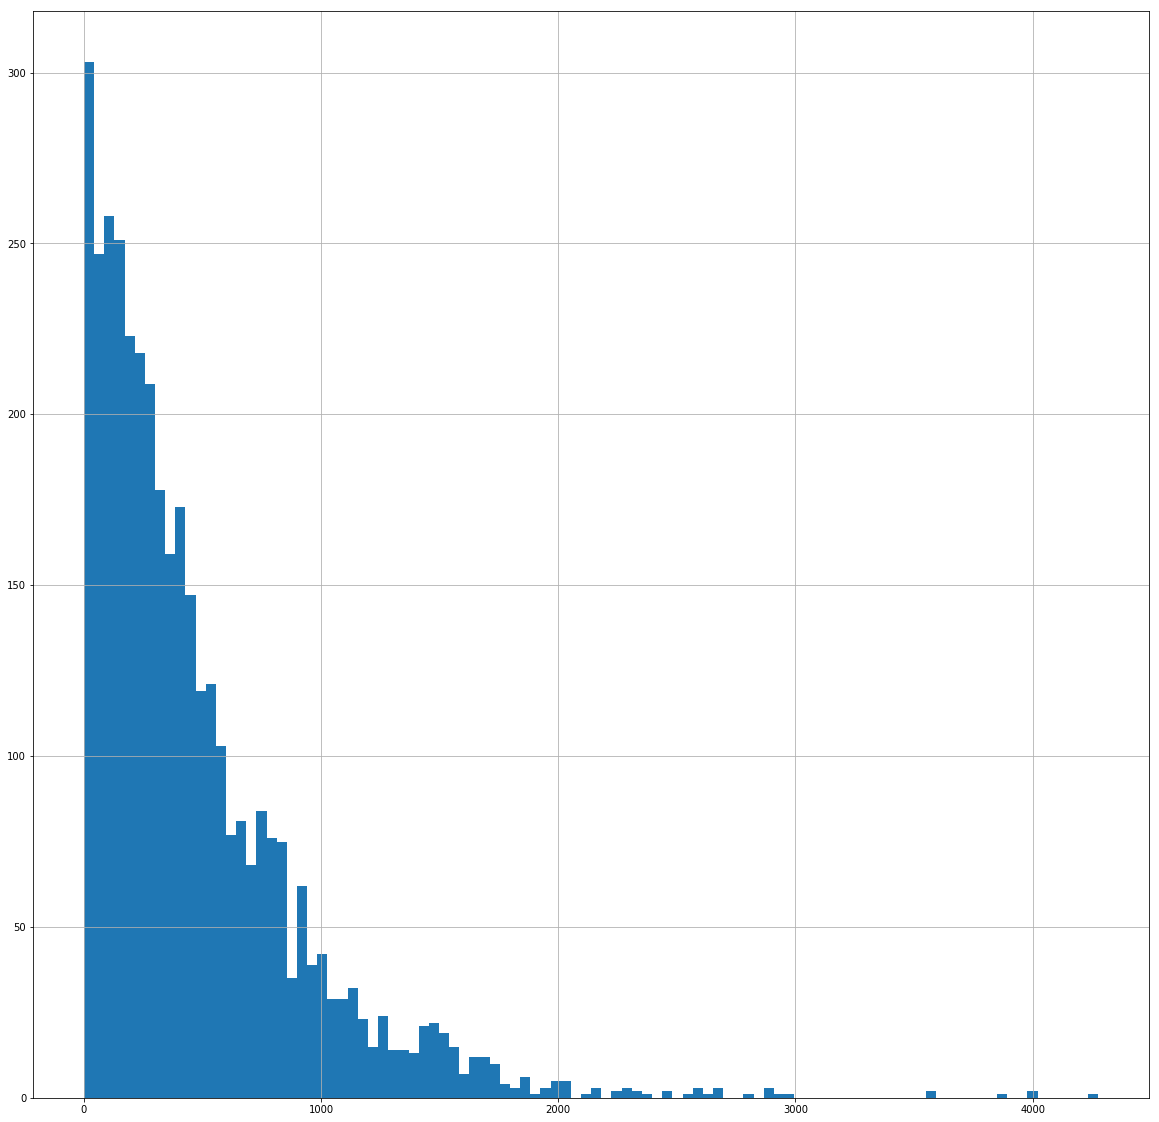

In [90]:
y_train.hist(bins =100, figsize=(20,20))
# распределение смещено в сторону нуля в реаль ности значения в два раза больше

In [51]:
y_train.unique()

array([613.71, 547.31,  -1.  , ..., 918.14, 721.44, 742.53])

In [55]:
len(y_train[y_train==0])

1044

In [58]:
len(dates_cat)

4764

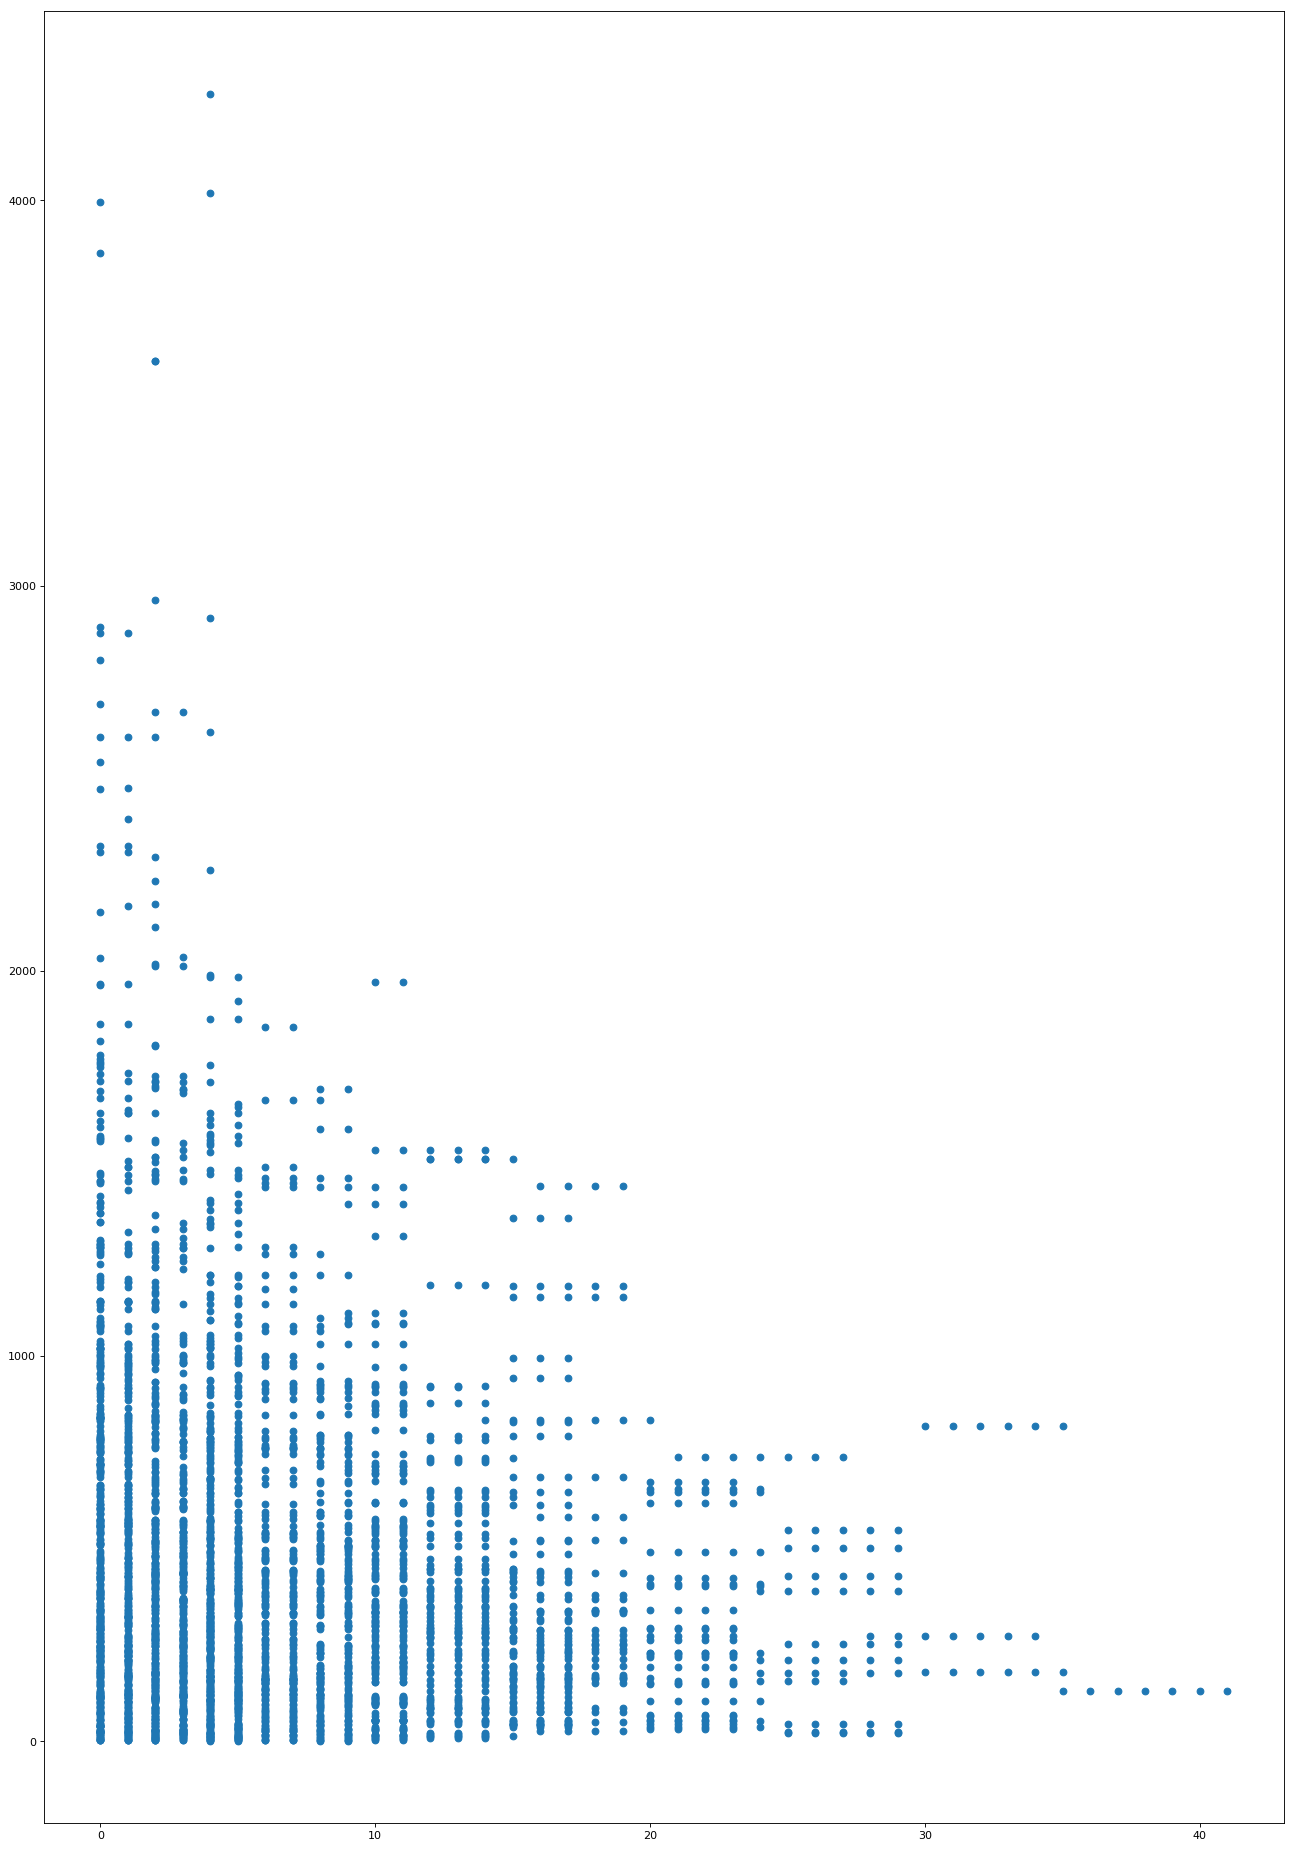

In [92]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 30), dpi=80)
plt.scatter(dates_cat.loc[y_train.index],y_train)

In [84]:
train.loc[y_train[y_train==-1].index]

Скважина        Дата  ГТМ Метод Характер работы  \
2     53514b4c4150ad897d82dd7d42cfc1a5  2014-12-01  NaN   NaN             NaN   
5     53514b4c4150ad897d82dd7d42cfc1a5  2015-01-01  NaN   NaN             NaN   
6     fe017a547ac58cc7366a60cc6bcd3915  2013-12-01  NaN   NaN             NaN   
7     fe017a547ac58cc7366a60cc6bcd3915  2014-12-01  NaN   NaN             NaN   
8     fe017a547ac58cc7366a60cc6bcd3915  2014-01-01  NaN   NaN             NaN   
9     fe017a547ac58cc7366a60cc6bcd3915  2015-01-01  NaN   NaN             NaN   
10    fe017a547ac58cc7366a60cc6bcd3915  2014-01-29  NaN   NaN             NaN   
11    fe017a547ac58cc7366a60cc6bcd3915  2015-01-29  NaN   NaN             NaN   
12    8f3131afe66d3266c23142786786b265  2014-12-01  NaN   NaN             NaN   
13    8f3131afe66d3266c23142786786b265  2015-01-01  NaN   NaN             NaN   
14    8f3131afe66d3266c23142786786b265  2015-01-29  NaN   NaN             NaN   
15    8f3131afe66d3266c23142786786b265  2015-03-01  NaN   NaN             NaN   
21    cda627efd1549ecb72fa7931685d5aa3  2014-12-01  NaN   NaN             NaN   
40    d147dc766cf90a35a2db9d26a82746aa  2014-12-01  NaN   NaN             NaN   
45    db9947ee0fbc7f53447ab68bca6af0a1  2014-12-01  NaN   NaN             NaN   
64    820cd70e741321f99e67a46ef97a9a32  2014-12-01  NaN   NaN             NaN   
75    a1917c7975c40face71c0090738836d6  2014-12-01  NaN   NaN             NaN   
92    5a4202dcf17adc169ba49fb8dcd29072  2014-12-01  NaN   NaN             NaN   
93    5a4202dcf17adc169ba49fb8dcd29072  2014-12-01  NaN   NaN             NaN   
127   f63abcb03598c7026c30a5e15c5f79fe  2014-12-01  NaN   NaN             NaN   
128   f63abcb03598c7026c30a5e15c5f79fe  2014-12-01  NaN   NaN             NaN   
129   f63abcb03598c7026c30a5e15c5f79fe  2014-12-01  NaN   NaN             NaN   
130   f63abcb03598c7026c30a5e15c5f79fe  2014-12-01  NaN   NaN             NaN   
131   f63abcb03598c7026c30a5e15c5f79fe  2014-12-01  NaN   NaN             NaN   
146   68a7b98a35fac011108c1cd70ee49ed3  2014-12-01  NaN   NaN             NaN   
147   68a7b98a35fac011108c1cd70ee49ed3  2014-12-01  NaN   NaN             NaN   
150   7de14f10c3041dc26bde644d77116518  2013-12-01  NaN   NaN             NaN   
151   7de14f10c3041dc26bde644d77116518  2014-01-01  NaN   NaN             NaN   
152   7de14f10c3041dc26bde644d77116518  2014-01-29  NaN   NaN             NaN   
153   7de14f10c3041dc26bde644d77116518  2014-03-01  NaN   NaN             NaN   
154   7de14f10c3041dc26bde644d77116518  2014-03-31  NaN   NaN             NaN   
155   7de14f10c3041dc26bde644d77116518  2014-05-01  NaN   NaN             NaN   
161   376092d0125ed4345b8882d332f005c9  2014-12-01  NaN   NaN             NaN   
183   139f7e08e0ee1482519ba728cbc592a1  2014-12-01  NaN   NaN             NaN   
184   139f7e08e0ee1482519ba728cbc592a1  2014-12-01  NaN   NaN             NaN   
185   139f7e08e0ee1482519ba728cbc592a1  2014-12-01  NaN   NaN             NaN   
224   a4ab7c0046095d0edaa9912a70bd9a24  2014-12-01  NaN   NaN             NaN   
225   a4ab7c0046095d0edaa9912a70bd9a24  2014-12-01  NaN   NaN             NaN   
226   a4ab7c0046095d0edaa9912a70bd9a24  2014-12-01  NaN   NaN             NaN   
227   a4ab7c0046095d0edaa9912a70bd9a24  2014-12-01  NaN   NaN             NaN   
243   8b6c2950e9411bab171d55c1c800845c  2014-12-01  NaN   NaN             NaN   
244   8b6c2950e9411bab171d55c1c800845c  2014-12-01  NaN   NaN             NaN   
245   8b6c2950e9411bab171d55c1c800845c  2014-12-01  NaN   NaN             NaN   
270   3eec5518468a51cd8052303486601247  2010-12-01  NaN   NaN             NaN   
271   3eec5518468a51cd8052303486601247  2010-12-01  NaN   NaN             NaN   
272   3eec5518468a51cd8052303486601247  2011-12-01  NaN   NaN             NaN   
273   3eec5518468a51cd8052303486601247  2011-12-01  NaN   NaN             NaN   
274   3eec5518468a51cd8052303486601247  2012-11-30  NaN   NaN             NaN   
275   3eec5518468a51cd8052303486601247  2012-11-30  NaN   NaN

In [93]:
y_train.mean()

466.51015322580645